In [1]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.tree import DecisionTreeClassifier
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import torchvision.models as models
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier



In [2]:
raw_dataset = datasets.ImageFolder('data', transform=transforms.ToTensor())
def compute_mean_std(dataset):
    mean = 0.0
    std = 0.0
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    for images, _ in loader:
        images = images.view(images.size(0), images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    mean /= len(dataset)
    std /= len(dataset)
    return mean, std

mean, std = compute_mean_std(raw_dataset)
print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.4636, 0.4570, 0.4485])
Std: tensor([0.2310, 0.1974, 0.1834])


In [3]:
size = 28
path = 'data'
batch_size=32
transform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(size),
    transforms.ToTensor(),
    transforms.Normalize([0.4001, 0.4313, 0.4275], [0.0229, 0.0205, 0.0189])
])

dataset = datasets.ImageFolder(root=path, transform=transform)

train_data, test_data = train_test_split(dataset, test_size=0.2)


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


# Cargar el modelo pre-entrenado
model = models.resnet18(pretrained=True, progress=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

def extract_features(loader, model):
    features = []
    labels = []
    for images, image_labels in loader:
        with torch.no_grad():
            outputs = model(images)
            features.extend(outputs.view(outputs.size(0), -1).numpy())
            labels.extend(image_labels.numpy())
    return np.array(features), np.array(labels)


# Extraer características de las imágenes
train_features, train_labels = extract_features(train_loader, model)
valid_features, valid_labels = extract_features(test_loader, model)

X_train = train_features
y_train = train_labels
X_test = valid_features
y_test = valid_labels

n_classes = len(np.unique(y_test))


def metrics(y_test, y_pred, title):
    print(f"Resultados para el modelo {title}")
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("F1", f1_score(y_test, y_pred, average='weighted'))
    print("Recall", recall_score(y_test, y_pred, average='weighted'))
    print("Precision", precision_score(y_test, y_pred, average='weighted'))

def plot_multiclass_roc_auc(y_true, y_pred_proba, n_classes):
    # Calcular las curvas ROC y AUC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Graficar las curvas ROC y mostrar las AUC en la leyenda
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i}: AUC = {roc_auc[i]:.2f}")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title('Curva ROC multiclase')
    plt.legend(loc="lower right")
    plt.show()    

C:\Users\LuisRa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\LuisRa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

# SVC

In [5]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear', 'poly'],'decision_function_shape': ['ovo', 'ovr']}

grid_search=GridSearchCV(SVC(probability=True),param_grid,cv=5,n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("Mejor score encontrado:")
print(grid_search.best_score_)

Mejores hiperparámetros encontrados:
{'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'poly'}
Mejor score encontrado:
0.8622222222222223


In [6]:
svcClassifier = SVC(C=grid_search.best_params_['C'],kernel= grid_search.best_params_['kernel'], gamma=grid_search.best_params_['gamma'], probability=True, decision_function_shape=grid_search.best_params_['decision_function_shape'])
svcClassifier.fit(X_train_scaled, y_train)
y_predSVC = svcClassifier.predict(X_test_scaled)
metrics(y_test, y_predSVC, "SVC")

Resultados para el modelo SVC
Accuracy:  0.88
F1 0.8816717365507978
Recall 0.88
Precision 0.8901925925925926


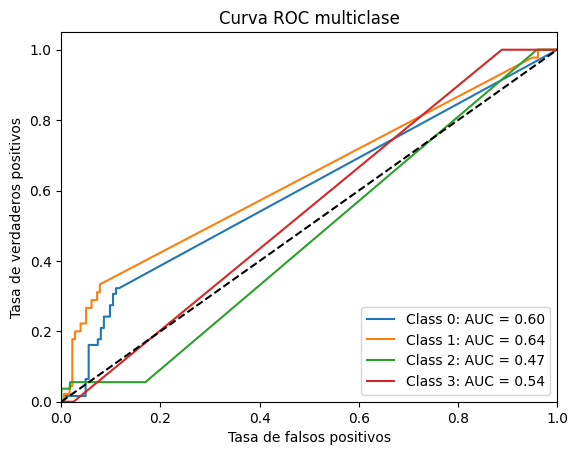

In [7]:
plot_multiclass_roc_auc(y_test, svcClassifier.predict_proba(X_test), n_classes)

# Decission Tree

In [8]:
param_grid = {'criterion':['gini','entropy'],'max_depth':[4,8,12,20,50,120,150],'splitter':['best','random']}
dt_grid_search = GridSearchCV(DecisionTreeClassifier(),param_grid,cv=5,n_jobs=-1)
dt_grid_search.fit(X_train, y_train)
 
print("Mejores hiperparámetros encontrados:")
print(dt_grid_search.best_params_)
print("Mejor score encontrado:")
print(dt_grid_search.best_score_)

Mejores hiperparámetros encontrados:
{'criterion': 'entropy', 'max_depth': 50, 'splitter': 'best'}
Mejor score encontrado:
0.7966666666666666


In [9]:
dt_classifier = DecisionTreeClassifier(criterion=dt_grid_search.best_params_['criterion'],max_depth=dt_grid_search.best_params_['max_depth'],splitter=dt_grid_search.best_params_['splitter'])
dt_classifier.fit(X_train, y_train)
y_pred_DT = dt_classifier.predict(X_test)
metrics(y_test, y_pred_DT, "Decision Tree")

Resultados para el modelo Decision Tree
Accuracy:  0.8444444444444444
F1 0.8434855052209412
Recall 0.8444444444444444
Precision 0.8444613181180346


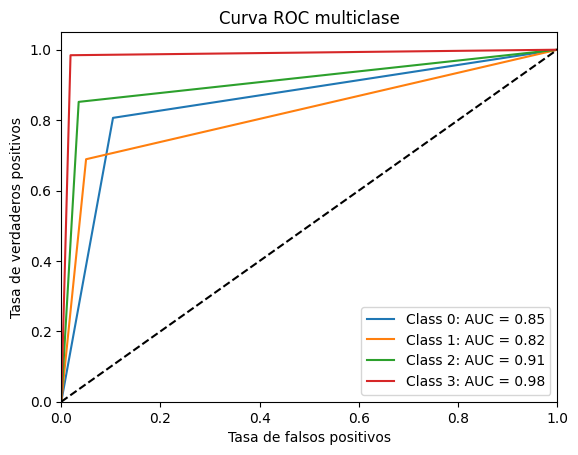

In [10]:
plot_multiclass_roc_auc(y_test, dt_classifier.predict_proba(X_test), n_classes)

# Random Forest

In [15]:
param_grid = {'n_estimators':[10,50,100,200,500,1000],'criterion':['gini','entropy'],'max_depth':[4,8,12,20,50,120,150]}
rf_grid_search = GridSearchCV(RandomForestClassifier(),param_grid,cv=5,n_jobs=-1)

rf_grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(rf_grid_search.best_params_)
print("Mejor score encontrado:")
print(rf_grid_search.best_score_)

Mejores hiperparámetros encontrados:
{'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 100}
Mejor score encontrado:
0.8733333333333334


In [16]:
rf_classifier = RandomForestClassifier(n_estimators=rf_grid_search.best_params_['n_estimators'],criterion=rf_grid_search.best_params_['criterion'],max_depth=rf_grid_search.best_params_['max_depth'])
rf_classifier.fit(X_train, y_train)

y_pred_RF = rf_classifier.predict(X_test)

metrics(y_test, y_pred_RF, "Random Forest")

Resultados para el modelo Random Forest
Accuracy:  0.8977777777777778
F1 0.8974958718310685
Recall 0.8977777777777778
Precision 0.8992781395575998


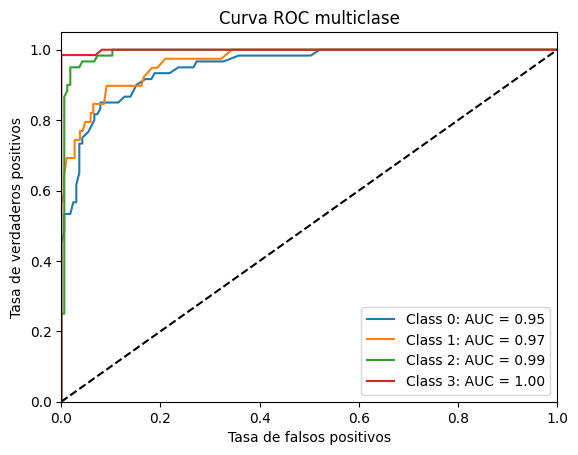

In [18]:
plot_multiclass_roc_auc(y_test, rf_classifier.predict_proba(X_test), n_classes)

# Extra Trees

In [11]:
param_grid = {'criterion':['gini','entropy'],'max_depth':[4,8,12,20,50,120,150],'splitter':['best','random']}

et_grid_search = GridSearchCV(ExtraTreeClassifier(),param_grid,cv=5,n_jobs=-1)
et_grid_search.fit(X_train, y_train)
print(et_grid_search.best_params_)
print(et_grid_search.best_score_)

{'criterion': 'gini', 'max_depth': 120, 'splitter': 'best'}
0.7622222222222221


In [12]:
et_classifier = ExtraTreeClassifier(criterion=et_grid_search.best_params_['criterion'],max_depth=et_grid_search.best_params_['max_depth'],splitter=et_grid_search.best_params_['splitter'])
et_classifier.fit(X_train, y_train)
er_y_pred=et_classifier.predict(X_test)
metrics(y_test, er_y_pred, "Extra Tree")

Resultados para el modelo Extra Tree
Accuracy:  0.7511111111111111
F1 0.750666452591821
Recall 0.7511111111111111
Precision 0.7505871761149299


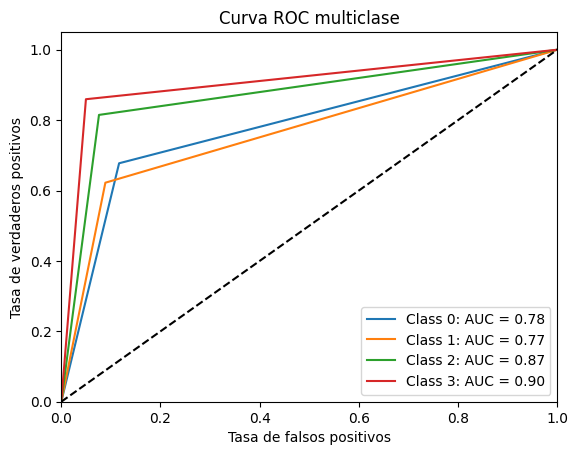

In [13]:
plot_multiclass_roc_auc(y_test, et_classifier.predict_proba(X_test), n_classes)

# Export the best model

In [22]:
import joblib

joblib.dump(rf_classifier, "my_model.pkl", compress=1)

['my_model.pkl']